# Hydrogen molecule with DFT
---

The calculation starts with importing necessary tools for the calculation

In [1]:
# Command importing plotting and numerical functions
%pylab inline

# Atomic Simulation Environment tools
from ase import Atoms                      # Object representing groups of atoms
from ase.units import Ry, Bohr             # Unit conversion constants
from ase.calculators.abinit import Abinit  # AbInit DFT program interface
from ase.visualize.plot import plot_atoms  # Simple plotting function

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Construction of the molecule

Here we build the H$_2$ molecule inside a 10x10x10 Angstrom box. The atoms are separated by 1A distance. We check the result by simple plot.

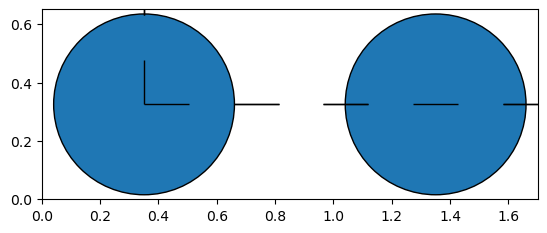

In [2]:
H2 = Atoms("H2", positions=[(0,0,0),(1,0,0)], cell=[10, 10, 10])
plot_atoms(H2, colors=2*['C0'], show_unit_cell=1);

### Defining DFT calculator

Define the AbInit calculator object with all required parameters:

* `label` name
* `nbands` number of electronic bands per atom
* `ecut` cutoff energy for the plane wave representation of wavefunctions
* `kpts` grid of k-points for reciprocal space integration
* `toldfe` convergence criterion for electronic states iteration
* `xc` exchange type to use in the calculation (LDA, PBE)
* `pps` variant of the pseudopotential (fhi and hgh are installed, others are available)
* `directory` working directory for the calculation
* `v8_legacy_format=True` required for abinit v8 compatibility

The variables marked with double exclamation points (!!) are critical for the accuracy or sometimes even validity of the results. After defining the calculator we assign it to the H2 molecule defined above. The parameters used here are optimized for speed *not* accuracy.

In [3]:
calc = Abinit(nbands=2,           # !!
              ecut= 8 * Ry,       # !! 
              kpts=[1, 1, 1],     # !!
              toldfe=1.0e-3,      # !!
              xc='LDA',           # try 'PBE'
              pps='fhi',
              directory="work_01")

H2.calc = calc

Finally, we can run a simple calculation of total energy of the H2 molecule.

In [4]:
H2.get_potential_energy()

-28.6855076336419

## Calculation of H2 bond length

To calculate the equilibrium bond length of the molecule we need to plot energy (`E`)
of the molecule for several H-H distances `d` and find its minimum by fitting the 4$^{th}$ order polynomial to the data points and locating its minimum by finding root of the derivative.

First we calculate, for few distances `d` in the range 1-2A, energies `E` and forces `F` and put them in two lists `EvsD` and `FvsD` respectively.

In [5]:
EvsD = []
FvsD = []
print('   d      E      F\n---------------------')
for d in np.linspace(1, 2, 7):
    H2.set_positions([(0,0,-d*Bohr/2),(0,0,d*Bohr/2)])
    E = H2.get_potential_energy()
    F = H2.get_forces()[0,2]
    EvsD.append([d, E])
    FvsD.append([d, F])
    print(f'{d:5.2f}: {E:6.2f} {F:6.2f}')

   d      E      F
---------------------
 1.00: -26.23 -27.36
 1.17: -27.98 -13.67
 1.33: -28.80  -5.60
 1.50: -29.06  -0.90
 1.67: -29.01   1.74
 1.83: -28.78   3.11
 2.00: -28.47   3.72


Reorganize the lists into a matrix (array) for easier manipulation.

In [6]:
FvsD = np.array(FvsD).T
EvsD = np.array(EvsD).T

### Find minimum of $E(d)$

Fit the fourth order polynomial to the data and find its minimum by finding root of its derivative. The derivative is calculated by standard formula for polynomials. We select a real root between 0.5 and 1. We use here a compact form of iteration known in python as *list comprehensions*.

In [7]:
fit = polyfit(EvsD[0]*Bohr, EvsD[1], 4)

mpos = [real(r) for r in roots(fit[:-1] * np.arange(4,0,-1)) 
        if abs(imag(r))<1e-3 and real(r) < 1 and real(r) > 0.5][0]

Finally we plot everything on the simple graph.

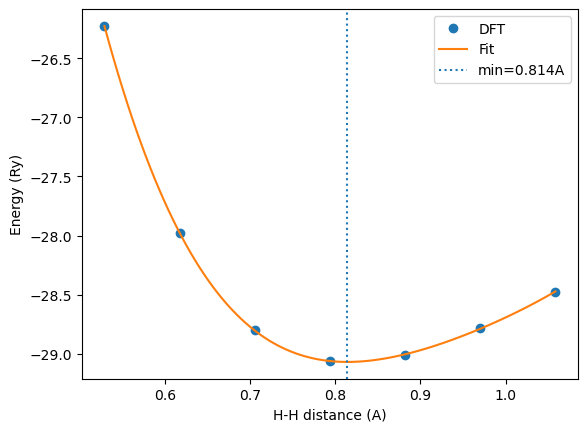

In [8]:
plot(EvsD[0]*Bohr, EvsD[1], "o", label='DFT')
d = linspace(1*Bohr,2*Bohr,100)
plot(d, np.polyval(fit, d), "-", label='Fit')
axvline(mpos, ls=':', label=f'min={mpos:.3f}A')
xlabel('H-H distance (A)')
ylabel('Energy (Ry)')
legend();

### Find $F(d)=0$

Alternatively, we can find the place where interatomic forces in the molecule cross zero. We have already calculated the forces with energy. We only need to fit another polynomial and find its real root in the (0.5, 1) A range.

In [9]:
fit = np.polyfit(FvsD[0]*Bohr, FvsD[1], 4)

mpos = [np.real(r) for r in np.roots(fit) 
        if abs(np.imag(r))<1e-3 and real(r) < 1 and real(r) > 0.5][0]

Plot the results

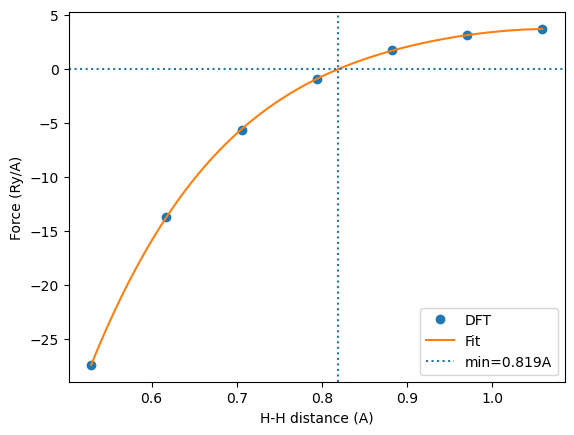

In [10]:
plot(FvsD[0]*Bohr, FvsD[1], "o", label="DFT")
d = linspace(1*Bohr,2*Bohr,100)
plot(d, np.polyval(fit, d), "-", label="Fit")
axvline(mpos, ls=':', label=f'min={mpos:.3f}A')
axhline(ls=':')
xlabel('H-H distance (A)')
ylabel('Force (Ry/A)')
legend();